# Aim to compare decision tree visulization with subgroup discovery

In [1]:
import sys
sys.path.append('..')
import shapSD as ssd
import pandas as pd
from sklearn.model_selection import train_test_split

Using TensorFlow backend.


In [2]:
credit_file_path = '../data/german_credit_data.csv'
df_credit = pd.read_csv(credit_file_path, index_col=0)
credit = ssd.DataEncoder(df_credit).onehot_encoding()
credit.head()

,Age,Job,Credit amount,Duration,Sex_male,Housing_own,Housing_rent,Saving accounts_moderate,Saving accounts_quite rich,Saving accounts_rich,Checking account_moderate,Checking account_rich,Purpose_car,Purpose_domestic appliances,Purpose_education,Purpose_furniture/equipment,Purpose_radio/TV,Purpose_repairs,Purpose_vacation/others,Risk_good
0,67,2,1169,6,1,1,0,0,0,0,0,0,0,0,0,0,1,0,0,1
1,22,2,5951,48,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,0
2,49,1,2096,12,1,1,0,0,0,0,0,0,0,0,1,0,0,0,0,1
3,45,2,7882,42,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1
4,53,2,4870,24,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0


In [3]:
# x, y = credit.drop('Risk_good', axis=1), credit['Risk_good']
# x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.15, random_state=42)

In [4]:
x_train, y_train = credit.drop('Risk_good', axis=1), credit['Risk_good']
clf_credit = ssd.InitializeModel(x_train, y_train).lgb_clf_model()

In [5]:
def draw_decision_tree(attr, target_name, credit_shap):
    dtree_exp = ssd.DecisionTreeExplain(credit_shap.drop([attr, target_name], axis=1), credit_shap.iloc[:, -1])
    estimator = dtree_exp.dtree_reg_model(max_depth=3)
    if len(attr.split(' ')) > 1:
        file_name = attr.split(' ')[0] + '_' + attr.split(' ')[1]
    else:
        file_name = attr
    return dtree_exp.visualize_dtree(estimator, '{}_effect'.format(file_name))

In [6]:
def subgroup_discovery(df_effect, target_name, label_name, selected_attr, measure):
    target = ssd.NumericTarget(target_name)
    search_space = ssd.create_selectors(df_effect, nbins=10, ignore=[target_name, label_name, selected_attr])
#     print(search_space)
    task = ssd.SubgroupDiscoveryTask(df_effect, target, search_space, qf=measure, result_set_size=10)
    result = ssd.BeamSearch().execute(task)
#     result = ssd.overlap_filter(result, df_effect, similarity_level=0.85)
    df_result = ssd.as_df(df_effect, result, statistics_to_show=ssd.all_statistics_numeric)
    return df_result[['quality', 'subgroup', 'size_sg', 'mean_sg', 'mean_dataset', 'mean_lift']]

## Insepct the effect of varialbe "Credit amount"

In [7]:
exp_credit = ssd.ShapExplainer(x_train, clf_credit, explainer_type='Tree')
attr = 'Credit amount'
# attr = 'Job'
credit_shap = exp_credit.get_attr_shap_values(attr=attr)

### Decision tree visualization

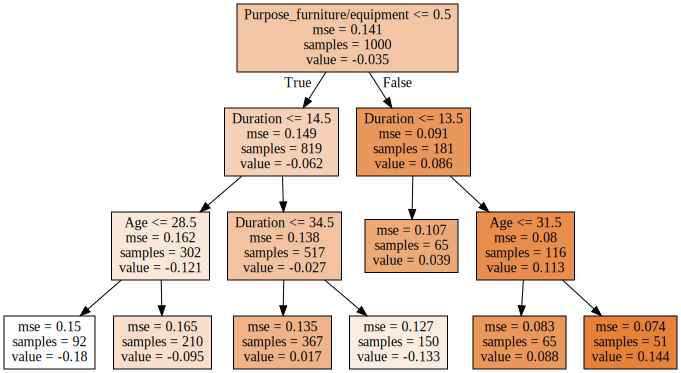

In [8]:
target_name = credit_shap.columns.tolist()[-1]
draw_decision_tree(attr, target_name, credit_shap)

### Subgroup discovery

In [9]:
df_effect = df_credit.copy()
df_effect[target_name] = credit_shap[target_name]
df_result = subgroup_discovery(df_effect, target_name, label_name='Risk', 
                               selected_attr=attr, measure=ssd.GAStandardQFNumeric(1))

In [11]:
df_result

,quality,subgroup,size_sg,mean_sg,mean_dataset,mean_lift
0,0.015590,Purpose=furniture/equipment,181.0,0.086134,-0.034825,-2.473365
1,0.009869,Duration: [18:24[,153.0,0.064505,-0.034825,-1.852284
2,0.007420,Duration: [24:30[ AND Job=2,133.0,0.078602,-0.034825,-2.257100
3,0.006187,Age: [33:36[,105.0,0.058926,-0.034825,-1.692074
4,0.004586,Duration: [24:30[,201.0,0.022816,-0.034825,-0.655160
5,0.004002,Duration: [15:18[,66.0,0.060639,-0.034825,-1.741273
6,0.003175,Duration: [18:24[ AND Housing=own,115.0,0.092111,-0.034825,-2.645014
7,0.003139,Duration: [24:30[ AND Saving accounts=moderate,25.0,0.148366,-0.034825,-4.260378
8,0.002949,Duration: [18:24[ AND Sex=male,99.0,0.094294,-0.034825,-2.707691
9,0.002906,Duration: [24:30[ AND Purpose=radio/TV,54.0,0.076625,-0.034825,-2.200310


## Inspect the effect of varialbe "Job"

In [46]:
exp_credit = ssd.ShapExplainer(x_train, clf_credit, explainer_type='Tree')
attr = 'Job'
credit_shap = exp_credit.get_attr_shap_values(attr=attr)

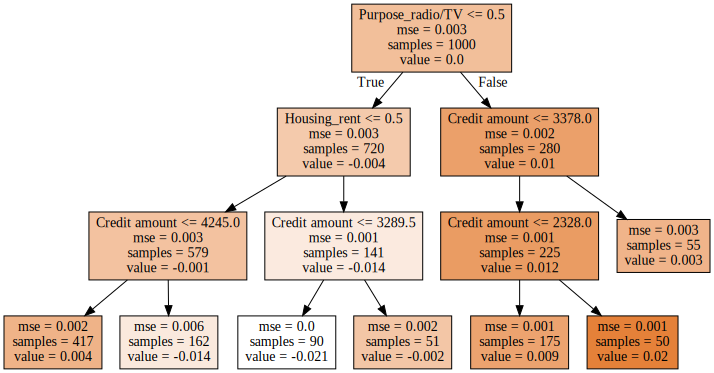

In [47]:
target_name = credit_shap.columns.tolist()[-1]
draw_decision_tree(attr, target_name, credit_shap)

In [48]:
df_effect = df_credit.copy()
df_effect[target_name] = credit_shap[target_name]
df_result = subgroup_discovery(df_effect, target_name, label_name='Risk', 
                               selected_attr=attr, measure=ssd.GAStandardQFNumeric(1))
df_result.head()

,quality,subgroup,size_sg,mean_sg,mean_dataset,mean_lift
0,0.002740,Purpose=radio/TV,280.0,0.009977,0.00019,52.457032
1,0.001207,Sex=male,690.0,0.001940,0.00019,10.197520
2,0.001068,Credit amount: [2848:3590[,100.0,0.010874,0.00019,57.170935
3,0.001033,Housing=own,713.0,0.001639,0.00019,8.616877
4,0.000922,Housing=free,108.0,0.008730,0.00019,45.900225
